In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np

In [74]:
from toolkit import trappist1, transit_model, trappist_out_of_transit, trappist1_all_transits
from copy import deepcopy

g = trappist1('g')
original_g = deepcopy(g)
b = trappist1('b')
c = trappist1('c')

In [75]:
from glob import glob
lc_paths = sorted(glob('all_transits/phot*'))
midtransit_times = len(lc_paths) * [g.t0]

-0.0364806912839


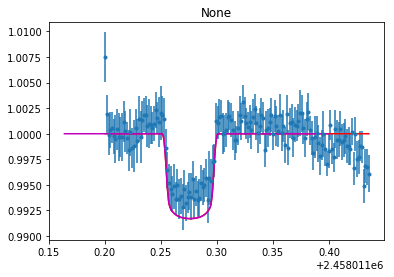

-0.000225433614105


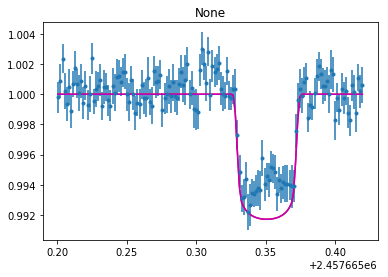

0.00134913343936


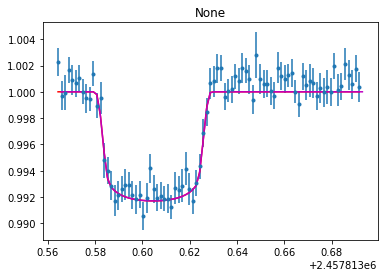

0.00131090264767


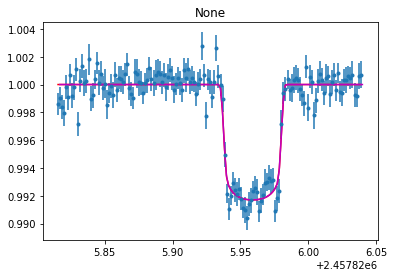

-0.00743575580418


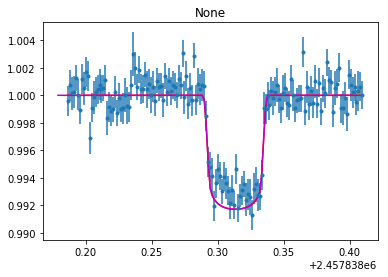

In [97]:

all_times = []

for i, path, midtransit_time in zip(np.arange(len(lc_paths)), lc_paths, midtransit_times):

    for j in range(2):
        bjd, flux, err, x, y, fwhm, fwhmx, fwhmy, bg, airmass, exptime = np.loadtxt(path, unpack=True)
        all_times.append(bjd)
        bjd += 2450000

        if j == 1: 
            g.t0 = midtransit_times[i]
            
        transit_model_g = transit_model(bjd, g)
        all_transits = trappist1_all_transits(bjd)

        oot = all_transits == 1

        X_all = np.vstack([x, y, fwhmx, fwhmy, np.ones_like(x)]).T

        X = X_all[oot, :]

        omega = np.diag(err[oot]**2)
        omega_inv = np.linalg.inv(omega)

        V = np.linalg.inv(X.T @ omega_inv @ X)
        beta = V @ X.T @ omega_inv @ flux[oot]

        regressed_lc = flux - (X_all @ beta) + 1
        regressed_lc /= np.median(regressed_lc)

        from scipy.optimize import fmin_powell, fmin_l_bfgs_b

        def minimize_this(p):
            return abs(np.sum((regressed_lc[oot] - transit_model_g[oot])**2 / 
                              (p[0] * err[oot])**2)/len(regressed_lc[oot]) - 1)

        err_scale = fmin_powell(minimize_this, [1], disp=False)
        err *= err_scale


        def transit_model_t(p):
            params = deepcopy(g)
            params.t0 = p[0]
            return transit_model(bjd, params)

        def chi2(p):
            return np.sum((regressed_lc - transit_model_t(p))**2 / err**2)

        #result = fmin_powell(chi2, [bjd[np.argmin(regressed_lc)]], disp=False)
        #result = fmin_powell(chi2, [midtransit_time], disp=False)
        result = fmin_l_bfgs_b(chi2, [bjd[np.argmin(regressed_lc)]], approx_grad=True, 
                               bounds=[(bjd.min(), bjd.max())])[0]
        if j == 0: 
            midtransit_times[i] = result[0]
            
    n_transits = np.round((bjd.mean() - original_g.t0) / g.per)
    midtransit_time_offset = midtransit_times[i] - (original_g.t0 + n_transits*g.per)
    print(midtransit_time_offset)
    plt.errorbar(bjd - midtransit_time_offset, regressed_lc, err, fmt='.')
    
    np.savetxt('reduced_lcs/lightcurve_{}.txt'.format(i), np.vstack([bjd - midtransit_time_offset, regressed_lc, err]).T)
    plt.plot(bjd - midtransit_time_offset, transit_model_t(result), 'r')

    plt.plot(bjd, transit_model(bjd, original_g), 'm')

#     plt.plot(bjd, all_transits)
    plt.title(note)
    
    plt.show()

In [98]:
all_lcs = np.vstack([np.loadtxt(i) for i in glob('reduced_lcs/lightcurve_?.txt')])
np.savetxt('reduced_lcs/all_lightcurves.txt', all_lcs)